In [2]:
import rasterio
import glob
import os,sys
from skimage.transform import rescale, resize, downscale_local_mean
from matplotlib import pyplot as plt
import numpy as np
from scipy import misc
import fiona
import geopandas as gpd
from shapely.geometry import shape
import shapely
from rasterio.mask import mask
from pyproj import Proj, transform

%matplotlib inline

In [6]:
# convert bounding boxes into string required for DG CatalogImage
# ex. bbox = [-110.85299491882326,32.167148499672855,-110.84870338439943,32.170236308395644] WGS84
def rioBoundBoxUTM_toWGS84(bounds_obj, src_crs, wgs84='4326'):
    
    wgs = Proj(init='epsg:{}'.format(wgs84))
    p2 = Proj(init=str(src_crs['init']))
    
    try:
        min_x, min_y = transform(p2, wgs, bounds_obj.left, bounds_obj.bottom)
        max_x, max_y = transform(p2, wgs, bounds_obj.right, bounds_obj.top)
    except:
        min_x, min_y = transform(p2, wgs, bounds_obj[0], bounds_obj[1])
        max_x, max_y = transform(p2, wgs, bounds_obj[2], bounds_obj[3])
    
    return min_x, min_y, max_x, max_y

def rioBoundBoxWGS84_toUTM(bounds_obj, src_crs, wgs84='4326'):
    
    #print(src_crs['init'])
    wgs = Proj(init='epsg:{}'.format(wgs84))
    #p2 = Proj(init=str(src_crs['init']))
    p2 = Proj(init='epsg:{}'.format(str(src_crs['init'])))
    min_x, min_y = transform(wgs, p2, bounds_obj[0], bounds_obj[1])
    max_x, max_y = transform(wgs, p2, bounds_obj[2], bounds_obj[3])
    
    return min_x, min_y, max_x, max_y

# define a function to check the image bounds of the two datasets
def imageIntersectionTest(dg_bounds, planet_bounds):
    
    res = ''
    if dg_bounds[0] > planet_bounds[0]:
        res += ' DG xmin is gt PL xmin'
        
    if dg_bounds[1] > planet_bounds[1]:
        res += ' DG ymin is  gt PL ymin'
        
    if dg_bounds[2] < planet_bounds[2]:
        res += ' DG xmax is lt PL xmax'
        
    if dg_bounds[3] < planet_bounds[3]:
        res += ' DG ymax is lt PL ymax'
        
    return res

## define a function to get the chip dimensions from a larger bounding box and a chip dimension
def generateChipBoxesUTM(bbox, box_dim):
    
#     xmin, ymin, xmax, ymax = bbox.bounds
#     xmin_chips = np.arange(xmin, xmax - box_dim, box_dim)
#     xmax_chips = np.arange(xmin + box_dim, xmax, box_dim)
#     ymin_chips = np.arange(ymin, ymax - box_dim, box_dim)
#     ymax_chips = np.arange(ymin + box_dim, ymax, box_dim)
    
    
    # try a for loop
    for_loop_result = []
    for l_x in np.arange(xmin, xmax-box_dim, box_dim):
        for l_y in np.arange(ymin, ymax-box_dim, box_dim):
            res = [l_x, l_y, l_x + box_dim, l_y + box_dim ]
            for_loop_result.append(res)
    
    return  for_loop_result

def generateChipBoxesUTM_WGS84(bbox, box_dim, crs):
    
    # get bounds
    xmin, ymin, xmax, ymax = bbox.bounds
    print(xmax-xmin)
    print(ymax-ymin)
    
    # try a for loop
    utm_chips = []
    wgs84_chips = []
    
    # construct chip bounds
    for l_x in np.arange(xmin, xmax-box_dim, box_dim):
        for l_y in np.arange(ymin, ymax-box_dim, box_dim):
            
            res = [l_x, l_y, l_x + box_dim, l_y + box_dim ]
            utm_chips.append(res)
            arg = box(res[0], res[1], res[2], res[3]).bounds
            wgs84_chips.append( rioBoundBoxUTM_toWGS84(arg, crs))
            
    return utm_chips, wgs84_chips

def chip_planet_image(impath, bbox, out_file):
    
    first = (bbox[0], bbox[1])    # xmin, ymin
    second = (bbox[0], bbox[3])   # xmin, ymax
    third = (bbox[2], bbox[3])    # xmax, ymax
    fourth = (bbox[2], bbox[1])   # xmax, ymin
    
    ## construct the geometry for rasterio.mask.mask
    bbox_geom = shapely.geometry.Polygon([first, second, third, fourth, first])
    geom = [shapely.geometry.mapping(bbox_geom)]
    
    # read the image
    with rasterio.open(impath, 'r') as src:
        out_image, out_transform = mask(src, geom, crop=True)
        out_meta = src.meta.copy()
        
    # get some pixel metrics
    num_nonzero = np.count_nonzero(out_image[0,:,:])
    num_pixels = out_image[0,:,:].size
    ratio = float(num_nonzero) / float(num_pixels)
    
    ## skip this one if not enough pixels
    if ratio < 0.95:
        return False
    
    else: #continue with the writing
    
        # update the metadata
        out_meta.update({"driver": "GTiff",
                     "height": out_image.shape[1],
                     "width": out_image.shape[2],
                     "transform": out_transform})

        # write the file
        with rasterio.open(out_file, "w", **out_meta) as dest:
            dest.write(out_image)

        return True

def chip_dg_image(dg_scene, bbox, dg_out_file):
    
    print('bbox {}'.format(bbox))
    
    # get the aoi
    img_aoi = dg_scene.aoi(bbox=bbox)
    
    # save the file
#     print(dg_out_file)
    img_aoi.geotiff(path=dg_out_file)
    
    return


In [12]:
# specify scene id for DG data
dg_scene_id = '1030010057062200'

# specify image for 2.0 meter analysis
gt_image_2 = '../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif'
#gt_image_2 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_2_0.tif'

# specify images for 0.5 meter analysis
gt_image_05 = '../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif'
#gt_image_05 = 'C:/projects/smart_cities/Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif'

# specify the shapefile
shpfile = '../Denver_Sample_Sites/union/union_grid_index256.shp'
rows = []
with fiona.open(shpfile) as shp:
    crs = shp.crs
    for s in shp:
        rows.append(shape(s['geometry']))
        
        
#         shp_bounds = shp.bounds


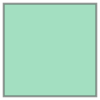

In [13]:
rows[0]

../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif


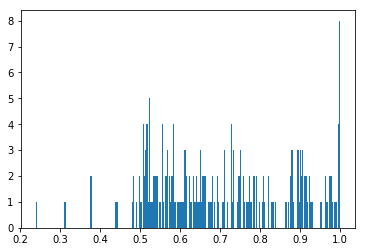

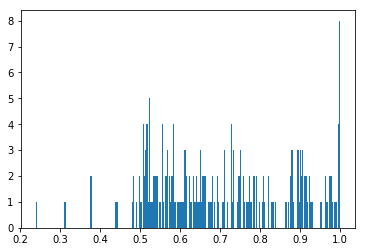

In [14]:
## check histogram of of number of pixels in image chip
# iterate the geometries

hist_list_05 = []
hist_list_2 = []

for gt_image, hs in zip([gt_image_05, gt_image_2], [hist_list_05, hist_list_2]):
    
    print(gt_image)
    for i, shp in enumerate(rows):

        bbox = shp.bounds
        bbox = rioBoundBoxWGS84_toUTM(shp.bounds, {'init': '32613'}, wgs84='4326') # image is in UTM
        
        first = (bbox[0], bbox[1])    # xmin, ymin
        second = (bbox[0], bbox[3])   # xmin, ymax
        third = (bbox[2], bbox[3])    # xmax, ymax
        fourth = (bbox[2], bbox[1])   # xmax, ymin

        ## construct the geometry for rasterio.mask.mask
        bbox_geom = shapely.geometry.Polygon([first, second, third, fourth, first])
        geom = [shapely.geometry.mapping(bbox_geom)]

        # read the image
        with rasterio.open(gt_image_05, 'r') as src:
            out_image, out_transform = mask(src, geom, crop=True)
            out_meta = src.meta.copy()

        # get some pixel metrics
        num_nonzero = np.count_nonzero(out_image[:,:])
        num_pixels = out_image[:,:].size
        ratio = float(num_nonzero) / float(num_pixels)

        hs.append(ratio)
        
array_2 = np.array(hist_list_2)
array_0_5 = np.array(hist_list_05)

plt.figure()
plt.hist(array_2, bins=256)
plt.show()

plt.figure()
plt.hist(array_0_5, bins=256)
plt.show()



### main chipping code.. first ground truth, then DG

In [15]:

gt_out_dir_list = ['gt_chips_2_0', 'gt_chips_0_5']
gt_images = [gt_image_2, gt_image_05]

i=0
for gt_im, gt_out_dir in zip(gt_images, gt_out_dir_list):
    
    # create the directory if it doesn't exist
    if not os.path.exists(gt_out_dir):
        os.mkdir(gt_out_dir)
    
    # define the basename of the file
    gt_chip_base = 'im_' + gt_out_dir
    
    # iterate the geometries
    for i, shp in enumerate(rows):
    
        # status
        print('on item {} of {}'.format(i+1, len(rows)))
        
        # form the output paths
        gt_out_im = '{}_{:0>12}.tif'.format(gt_chip_base, i)
        gt_out_file = os.path.join(gt_out_dir, gt_out_im)

        # chip the ground truth image
        bbox = rioBoundBoxWGS84_toUTM(shp.bounds, {'init': '32613'}, wgs84='4326') # image is in UTM
        
        print(gt_im)
        chip_planet_image(gt_im, bbox, gt_out_file)

        # update counter
        i+=1
        
        



on item 1 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 2 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 3 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 4 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 5 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 6 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 7 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 8 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 9 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 10 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 11 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 12 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 13 of

on item 112 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 113 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 114 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 115 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 116 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 117 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 118 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 119 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 120 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 121 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 122 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_0_0.tif
on item 123 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_2_

on item 13 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 14 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 15 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 16 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 17 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 18 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 19 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 20 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 21 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 22 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 23 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 24 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 25 of 204
../Denver_

on item 121 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 122 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 123 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 124 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 125 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 126 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 127 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 128 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 129 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 130 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 131 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 132 of 204
../Denver_Sample_Sites/rasters/union_impervious_raster_0_5.tif
on item 133 of 2

In [1]:
with rasterio.open(r"C:\Projects\smart_cities\Denver_Sample_Sites\rasters\union_impervious_raster_2_0_0.tif", 'r') as src:
    print (src.meta)

NameError: name 'rasterio' is not defined

In [14]:
from gbdxtools import CatalogImage

i=0
skip_ctr=0

# specify processing modes for list
ps_list = [True, False] # pansharpening flag
ac_list = [True, False] # AComp flag

# iterate through the flag possibilities
for ac in ac_list:
    for ps in ps_list:  
    
        if ac and ps: # AComp and Pansharpening

            ## specify directory
            dg_chip_dir = r'dg_chips_AC_PS_0_5'
            
        elif ac and not ps: # AComp and not Pansharpening

            ## specify directory
            dg_chip_dir = r'dg_chips_AC_MS_2_0'
            
        elif not ac and not ps: # not AComp and not Pansharpening

            ## specify directory
            dg_chip_dir = r'dg_chips_noAC_MS_2_0'
            
        else: # not AComp and Pansharpening

            ## specify directory
            dg_chip_dir = r'dg_chips_noAC_PS_0_5'

        
        # make a base for the filenames 
        dg_chip_base = 'im_' + dg_chip_dir
        
        
        ## make the directory if it doesn't exist
        if not os.path.exists(dg_chip_dir):
            os.makedirs(dg_chip_dir)

        ## get the image with AComp and Pansharpen parameters
        img = CatalogImage(dg_scene_id, acomp=ac, pansharpen=ps)           
        
        for i, shp in enumerate(rows):
            
            print ('on item {} of {}, for acomp {} and PS {}'.format(i+1, len(rows), ac, ps))
            # form the output paths
            dg_out_im = '{}_{:0>12}.tif'.format(dg_chip_base, i)
            dg_out_file = os.path.join(dg_chip_dir, dg_out_im)

            # chip the DG image
            chip_dg_image(img, shp.bounds, dg_out_file)
            
            

            # update counter
            i+=1






   

on item 1 of 204, for acomp True and PS True
bbox (-105.02266114632103, 39.72931185372713, -105.02035888188307, 39.73161411816508)
on item 2 of 204, for acomp True and PS True
bbox (-105.02035888188307, 39.72931185372713, -105.01805661744511, 39.73161411816508)
on item 3 of 204, for acomp True and PS True
bbox (-105.01805661744511, 39.72931185372713, -105.01575435300715, 39.73161411816508)
on item 4 of 204, for acomp True and PS True
bbox (-105.02496341075897, 39.72700958928918, -105.02266114632101, 39.72931185372713)
on item 5 of 204, for acomp True and PS True
bbox (-105.02266114632103, 39.72700958928918, -105.02035888188307, 39.72931185372713)
on item 6 of 204, for acomp True and PS True
bbox (-105.02035888188307, 39.72700958928918, -105.01805661744511, 39.72931185372713)
on item 7 of 204, for acomp True and PS True
bbox (-105.01805661744511, 39.72700958928918, -105.01575435300715, 39.72931185372713)
on item 8 of 204, for acomp True and PS True
bbox (-105.01575435300715, 39.72700958

on item 63 of 204, for acomp True and PS True
bbox (-105.00194076637943, 39.71319600266146, -104.99963850194148, 39.71549826709941)
on item 64 of 204, for acomp True and PS True
bbox (-105.03417246851079, 39.710893738223504, -105.03187020407283, 39.713196002661455)
on item 65 of 204, for acomp True and PS True
bbox (-105.03187020407283, 39.710893738223504, -105.02956793963487, 39.713196002661455)
on item 66 of 204, for acomp True and PS True
bbox (-105.02956793963489, 39.710893738223504, -105.02726567519693, 39.713196002661455)
on item 67 of 204, for acomp True and PS True
bbox (-105.02726567519693, 39.710893738223504, -105.02496341075897, 39.713196002661455)
on item 68 of 204, for acomp True and PS True
bbox (-105.02496341075897, 39.710893738223504, -105.02266114632101, 39.713196002661455)
on item 69 of 204, for acomp True and PS True
bbox (-105.02266114632103, 39.710893738223504, -105.02035888188307, 39.713196002661455)
on item 70 of 204, for acomp True and PS True
bbox (-105.0203588

on item 124 of 204, for acomp True and PS True
bbox (-105.03187020407283, 39.703986944909644, -105.02956793963487, 39.706289209347595)
on item 125 of 204, for acomp True and PS True
bbox (-105.02956793963489, 39.703986944909644, -105.02726567519693, 39.706289209347595)
on item 126 of 204, for acomp True and PS True
bbox (-105.02726567519693, 39.703986944909644, -105.02496341075897, 39.706289209347595)
on item 127 of 204, for acomp True and PS True
bbox (-105.02496341075897, 39.703986944909644, -105.02266114632101, 39.706289209347595)
on item 128 of 204, for acomp True and PS True
bbox (-105.02266114632103, 39.703986944909644, -105.02035888188307, 39.706289209347595)
on item 129 of 204, for acomp True and PS True
bbox (-105.02035888188307, 39.703986944909644, -105.01805661744511, 39.706289209347595)
on item 130 of 204, for acomp True and PS True
bbox (-105.01805661744511, 39.703986944909644, -105.01575435300715, 39.706289209347595)
on item 131 of 204, for acomp True and PS True
bbox (-1

on item 185 of 204, for acomp True and PS True
bbox (-104.99963850194149, 39.697080151595785, -104.99733623750353, 39.699382416033735)
on item 186 of 204, for acomp True and PS True
bbox (-104.99733623750353, 39.697080151595785, -104.99503397306557, 39.699382416033735)
on item 187 of 204, for acomp True and PS True
bbox (-104.99503397306557, 39.697080151595785, -104.99273170862762, 39.699382416033735)
on item 188 of 204, for acomp True and PS True
bbox (-104.99273170862763, 39.697080151595785, -104.99042944418967, 39.699382416033735)
on item 189 of 204, for acomp True and PS True
bbox (-105.00654529525535, 39.694777887157834, -105.00424303081739, 39.697080151595785)
on item 190 of 204, for acomp True and PS True
bbox (-105.00424303081739, 39.694777887157834, -105.00194076637943, 39.697080151595785)
on item 191 of 204, for acomp True and PS True
bbox (-105.00194076637943, 39.694777887157834, -104.99963850194148, 39.697080151595785)
on item 192 of 204, for acomp True and PS True
bbox (-1

on item 43 of 204, for acomp True and PS False
bbox (-105.02266114632103, 39.71549826709941, -105.02035888188307, 39.717800531537364)
on item 44 of 204, for acomp True and PS False
bbox (-105.02035888188307, 39.71549826709941, -105.01805661744511, 39.717800531537364)
on item 45 of 204, for acomp True and PS False
bbox (-105.01805661744511, 39.71549826709941, -105.01575435300715, 39.717800531537364)
on item 46 of 204, for acomp True and PS False
bbox (-105.01575435300715, 39.71549826709941, -105.0134520885692, 39.717800531537364)
on item 47 of 204, for acomp True and PS False
bbox (-105.01345208856921, 39.71549826709941, -105.01114982413125, 39.717800531537364)
on item 48 of 204, for acomp True and PS False
bbox (-105.01114982413125, 39.71549826709941, -105.0088475596933, 39.717800531537364)
on item 49 of 204, for acomp True and PS False
bbox (-105.0088475596933, 39.71549826709941, -105.00654529525534, 39.717800531537364)
on item 50 of 204, for acomp True and PS False
bbox (-105.0065452

on item 105 of 204, for acomp True and PS False
bbox (-105.02956793963489, 39.7062892093476, -105.02726567519693, 39.70859147378555)
on item 106 of 204, for acomp True and PS False
bbox (-105.02726567519693, 39.7062892093476, -105.02496341075897, 39.70859147378555)
on item 107 of 204, for acomp True and PS False
bbox (-105.02496341075897, 39.7062892093476, -105.02266114632101, 39.70859147378555)
on item 108 of 204, for acomp True and PS False
bbox (-105.02266114632103, 39.7062892093476, -105.02035888188307, 39.70859147378555)
on item 109 of 204, for acomp True and PS False
bbox (-105.02035888188307, 39.7062892093476, -105.01805661744511, 39.70859147378555)
on item 110 of 204, for acomp True and PS False
bbox (-105.01805661744511, 39.7062892093476, -105.01575435300715, 39.70859147378555)
on item 111 of 204, for acomp True and PS False
bbox (-105.01575435300715, 39.7062892093476, -105.0134520885692, 39.70859147378555)
on item 112 of 204, for acomp True and PS False
bbox (-105.01345208856

on item 166 of 204, for acomp True and PS False
bbox (-105.0433815262626, 39.699382416033735, -105.04107926182465, 39.701684680471686)
on item 167 of 204, for acomp True and PS False
bbox (-105.04107926182465, 39.699382416033735, -105.03877699738669, 39.701684680471686)
on item 168 of 204, for acomp True and PS False
bbox (-105.03877699738669, 39.699382416033735, -105.03647473294873, 39.701684680471686)
on item 169 of 204, for acomp True and PS False
bbox (-105.03647473294875, 39.699382416033735, -105.03417246851079, 39.701684680471686)
on item 170 of 204, for acomp True and PS False
bbox (-105.03417246851079, 39.699382416033735, -105.03187020407283, 39.701684680471686)
on item 171 of 204, for acomp True and PS False
bbox (-105.03187020407283, 39.699382416033735, -105.02956793963487, 39.701684680471686)
on item 172 of 204, for acomp True and PS False
bbox (-105.02956793963489, 39.699382416033735, -105.02726567519693, 39.701684680471686)
on item 173 of 204, for acomp True and PS False
b

on item 23 of 204, for acomp False and PS True
bbox (-105.02496341075897, 39.72010279597532, -105.02266114632101, 39.72240506041327)
on item 24 of 204, for acomp False and PS True
bbox (-105.02266114632103, 39.72010279597532, -105.02035888188307, 39.72240506041327)
on item 25 of 204, for acomp False and PS True
bbox (-105.02035888188307, 39.72010279597532, -105.01805661744511, 39.72240506041327)
on item 26 of 204, for acomp False and PS True
bbox (-105.01805661744511, 39.72010279597532, -105.01575435300715, 39.72240506041327)
on item 27 of 204, for acomp False and PS True
bbox (-105.01575435300715, 39.72010279597532, -105.0134520885692, 39.72240506041327)
on item 28 of 204, for acomp False and PS True
bbox (-105.01345208856921, 39.72010279597532, -105.01114982413125, 39.72240506041327)
on item 29 of 204, for acomp False and PS True
bbox (-105.01114982413125, 39.72010279597532, -105.0088475596933, 39.72240506041327)
on item 30 of 204, for acomp False and PS True
bbox (-105.0088475596933

on item 85 of 204, for acomp False and PS True
bbox (-105.02956793963489, 39.70859147378555, -105.02726567519693, 39.710893738223504)
on item 86 of 204, for acomp False and PS True
bbox (-105.02726567519693, 39.70859147378555, -105.02496341075897, 39.710893738223504)
on item 87 of 204, for acomp False and PS True
bbox (-105.02496341075897, 39.70859147378555, -105.02266114632101, 39.710893738223504)
on item 88 of 204, for acomp False and PS True
bbox (-105.02266114632103, 39.70859147378555, -105.02035888188307, 39.710893738223504)
on item 89 of 204, for acomp False and PS True
bbox (-105.02035888188307, 39.70859147378555, -105.01805661744511, 39.710893738223504)
on item 90 of 204, for acomp False and PS True
bbox (-105.01805661744511, 39.70859147378555, -105.01575435300715, 39.710893738223504)
on item 91 of 204, for acomp False and PS True
bbox (-105.01575435300715, 39.70859147378555, -105.0134520885692, 39.710893738223504)
on item 92 of 204, for acomp False and PS True
bbox (-105.01345

on item 147 of 204, for acomp False and PS True
bbox (-105.03187020407283, 39.70168468047169, -105.02956793963487, 39.703986944909644)
on item 148 of 204, for acomp False and PS True
bbox (-105.02956793963489, 39.70168468047169, -105.02726567519693, 39.703986944909644)
on item 149 of 204, for acomp False and PS True
bbox (-105.02726567519693, 39.70168468047169, -105.02496341075897, 39.703986944909644)
on item 150 of 204, for acomp False and PS True
bbox (-105.02496341075897, 39.70168468047169, -105.02266114632101, 39.703986944909644)
on item 151 of 204, for acomp False and PS True
bbox (-105.02266114632103, 39.70168468047169, -105.02035888188307, 39.703986944909644)
on item 152 of 204, for acomp False and PS True
bbox (-105.02035888188307, 39.70168468047169, -105.01805661744511, 39.703986944909644)
on item 153 of 204, for acomp False and PS True
bbox (-105.01805661744511, 39.70168468047169, -105.01575435300715, 39.703986944909644)
on item 154 of 204, for acomp False and PS True
bbox (-

on item 5 of 204, for acomp False and PS False
bbox (-105.02266114632103, 39.72700958928918, -105.02035888188307, 39.72931185372713)
on item 6 of 204, for acomp False and PS False
bbox (-105.02035888188307, 39.72700958928918, -105.01805661744511, 39.72931185372713)
on item 7 of 204, for acomp False and PS False
bbox (-105.01805661744511, 39.72700958928918, -105.01575435300715, 39.72931185372713)
on item 8 of 204, for acomp False and PS False
bbox (-105.01575435300715, 39.72700958928918, -105.0134520885692, 39.72931185372713)
on item 9 of 204, for acomp False and PS False
bbox (-105.02726567519693, 39.724707324851224, -105.02496341075897, 39.727009589289175)
on item 10 of 204, for acomp False and PS False
bbox (-105.02496341075897, 39.724707324851224, -105.02266114632101, 39.727009589289175)
on item 11 of 204, for acomp False and PS False
bbox (-105.02266114632103, 39.724707324851224, -105.02035888188307, 39.727009589289175)
on item 12 of 204, for acomp False and PS False
bbox (-105.020

on item 77 of 204, for acomp False and PS False
bbox (-105.00424303081739, 39.710893738223504, -105.00194076637943, 39.713196002661455)
on item 78 of 204, for acomp False and PS False
bbox (-105.00194076637943, 39.710893738223504, -104.99963850194148, 39.713196002661455)
on item 79 of 204, for acomp False and PS False
bbox (-105.0433815262626, 39.70859147378555, -105.04107926182465, 39.710893738223504)
on item 80 of 204, for acomp False and PS False
bbox (-105.04107926182465, 39.70859147378555, -105.03877699738669, 39.710893738223504)
on item 81 of 204, for acomp False and PS False
bbox (-105.03877699738669, 39.70859147378555, -105.03647473294873, 39.710893738223504)
on item 82 of 204, for acomp False and PS False
bbox (-105.03647473294875, 39.70859147378555, -105.03417246851079, 39.710893738223504)
on item 83 of 204, for acomp False and PS False
bbox (-105.03417246851079, 39.70859147378555, -105.03187020407283, 39.710893738223504)
on item 84 of 204, for acomp False and PS False
bbox (

on item 138 of 204, for acomp False and PS False
bbox (-104.99963850194149, 39.703986944909644, -104.99733623750353, 39.706289209347595)
on item 139 of 204, for acomp False and PS False
bbox (-104.99733623750353, 39.703986944909644, -104.99503397306557, 39.706289209347595)
on item 140 of 204, for acomp False and PS False
bbox (-105.04798605513851, 39.70168468047169, -105.04568379070055, 39.703986944909644)
on item 141 of 204, for acomp False and PS False
bbox (-105.04568379070055, 39.70168468047169, -105.04338152626259, 39.703986944909644)
on item 142 of 204, for acomp False and PS False
bbox (-105.0433815262626, 39.70168468047169, -105.04107926182465, 39.703986944909644)
on item 143 of 204, for acomp False and PS False
bbox (-105.04107926182465, 39.70168468047169, -105.03877699738669, 39.703986944909644)
on item 144 of 204, for acomp False and PS False
bbox (-105.03877699738669, 39.70168468047169, -105.03647473294873, 39.703986944909644)
on item 145 of 204, for acomp False and PS Fals

on item 202 of 204, for acomp False and PS False
bbox (-104.99963850194149, 39.690173358281925, -104.99733623750353, 39.692475622719876)
on item 203 of 204, for acomp False and PS False
bbox (-104.99733623750353, 39.690173358281925, -104.99503397306557, 39.692475622719876)
on item 204 of 204, for acomp False and PS False
bbox (-104.99503397306557, 39.690173358281925, -104.99273170862762, 39.692475622719876)


In [11]:
rows[0]

In [93]:
image_resized.shape


(4L, 30L, 30L)

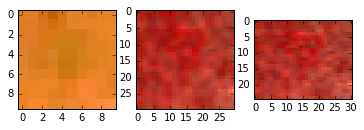

In [67]:
dg_arr.max(), image_resized.max(), image.dtype, image_resized.dtype

(2866, 2426.6049999999996, dtype('uint16'), dtype('float64'))

In [89]:
import skimage
skimage.__version__

'0.13.0'

In [ ]:
!conda update skimage